# Pythonic Code
## We Code Fest 2019 - Valladolid, Spain
Hey there! This jupyter notebook is part of a live coding talk called "Pythonic Code", hosted in the WeCodeFest 2019. This notebook will compare python scripts with a pythonic version of the same code. My intention is to show good practices and tricks in the Python programming language.

## File management
Files must be opened to perform any I/O operation with them. They must be closed too. It's a quite common mistake to forget about that, leaving the file descriptor unclosed. This can lead to errors when reaching the limit of open file descriptors. How does python help to prevent this situation? Using [**context managers**](https://docs.python.org/3/library/stdtypes.html#context-manager-types). Let's see an example.

In [1]:
myfile = open('test.txt', 'w')
myfile.write('test')
myfile.close()

In [2]:
with open('test.txt', 'w') as myfile:
    myfile.write('test')

When there's no more code to execute in the context manager, it *closes* itself calling the **`__exit__`** magic method. Objects defining this method (such as file objects) can be used in context managers. In the case of file objects, the **`__exit__`** method is in charge of closing the file descriptor.

## Command line arguments
It is very common to use `sys.argv` and `getopt` to parse arguments from command line. It works but python provides an easier way to do it: the **argparse** module.

In the `getopt` module documentation, the following note is present at the top of the page:
> The `getopt` module is a parser for command line options whose API is designed to be familiar to users of the C `getopt()` function. Users who are unfamiliar with the C `getopt()` function or who would like to write less code and get better help and error messages should consider using the `argparse` module instead. 

In [3]:
import getopt

argv = ["getopt_example.py", "--list", "--group=default"]


def usage():
    msg = """
    {0} [ -l [ -g group_id ]
    Usage:
    \t-l                                    # List all groups
    \t-l -g group_id                        # List agents in group

    Params:
    \t-l, --list
    \t-g, --group
    """.format(basename(argv[0]))
    print(msg)


arguments = {'n_args': 0, 'n_actions': 0, 'group': None, 'list': False}
try:
    opts, args = getopt.getopt(argv[1:], "lcafsSri:g:qdh", ["list", "group=", "help"])
    arguments['n_args'] = len(opts)
except GetoptError as err:
    print(str(err) + "\n" + "Try '--help' for more information.")
    exit(1)

for o, a in opts:
    if o in ("-l", "--list"):
        arguments['list'] = True
        arguments['n_actions'] += 1
    elif o in ("-g", "--group"):
        arguments['group'] = a
    elif o in ("-h", "--help"):
        usage()
    else:
        print("Invalid options.\nTry '--help' for more information.\n")

arguments

{'n_args': 2, 'n_actions': 1, 'group': 'default', 'list': True}

In [4]:
import argparse
parser = argparse.ArgumentParser(description='List groups or all agents inside a group.')
parser.add_argument('-l', '--list', help="List all groups", dest='list', action='store_true')
parser.add_argument('-g', '--group', help="List all agents in a group", dest='group', type=str)
parser.parse_args(['--list', '--group=default'])

Namespace(group='default', list=True)

## Type Hints
If you have worked inside a team, you'd probably know how it feels to read a function and not understand which type each parameter is. Is it a list? A integer? A string? This information is very useful, not only to make the code more readable but it also helps code editors (such as Pycharm) to highlight errors.

Since Python 3.5, Type Hints are available! Its syntax is the following:

In [5]:
def return_the_same_value(val: int) -> int:
    return val

In [6]:
return_the_same_value(5)

5

If the function is used with a different data type, it won't raise any run time errors:

In [7]:
return_the_same_value('hello')

'hello'

But the error will be highlighted in code editors, making it easier to detect them:
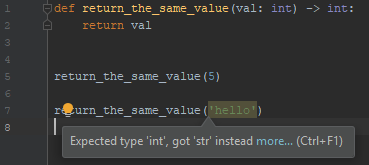

For more information about type hints, check the [docs](https://docs.python.org/3/library/typing.html).

## Iterators
### Lists/Dict/Set comprehesions
We all know what a for loop is, and we have all used one at any time in our lives. Python includes that too but it also includes much other ways to iterate.

The most basic one are lists comprehesions. Lists comprehesions builds a list in a single line. Let's compare creating a list using a "traditional method" and creating one using a list comprehesion.

In [8]:
%%time
my_list = []
for i in range(10000000):
    my_list.append(i)

Wall time: 1.13 s


In [9]:
%%time
my_list = [i for i in range(10000000)]

Wall time: 733 ms


In addition to list comprehesions, there are set comprehesions and dict comprehesions too!

In [10]:
%%time
import random
random_items = random.sample(range(1000000000), k=10000000)

Wall time: 8.42 s


In [11]:
%%time
my_dict = {}
for i in random_items:
    my_dict[i] = i

Wall time: 3.01 s


In [12]:
%%time
my_dict = {i:i for i in random_items}

Wall time: 2.82 s


In [13]:
%%time
my_set = set()
for i in random_items:
    my_set.add(i)

Wall time: 2.22 s


In [14]:
%%time
my_set = {i for i in random_items}

Wall time: 1.95 s


In [15]:
%%time
my_set = set(random_items)

Wall time: 1.32 s


As you can see, generally using a list/set/list comprehesion is faster than building it using a traditional for loop. Why? There is a few reasons:
* Using precompiled C code is faster than using interpreted python code
* Calling a function bound to a local name will be faster than calling a function in a external module.
* Avoid creating unnecessary lists in memory if your're only iterating them once: generators are faster.

## Unpacking tuples
To improve code's readability when iterating through any list/set/generator containing tuples it's possible to name each item in the tuple. For example, imagine we're iterating through a sql query in a database, each row contains the following  fields:
* Agent name
* Agent ID
* Agent IP
* Agent OS name

In [16]:
database_rows = [('my_manager', 0, '172.10.0.34', 'Ubuntu Bionic'),
                 ('my_1st_agent', 1, '183.24.64.1', 'CentOS 7'),
                 ('my_2nd_agent', 2, '193.142.144.12', 'Solaris 10')]

for row in database_rows:
    if row[1] > 0:
        print(row[3])

CentOS 7
Solaris 10


It's necessary to check databases's headers to know what `row[1]` and `row[3]` stands for. That makes the code harder to read and understand. But, in Python it is possible to ***unpack*** tuples:

In [17]:
for a_name, a_id, a_ip, a_os in database_rows:
    if a_id > 0:
        print(a_os)

CentOS 7
Solaris 10


This code looks much better, but we're only using two columns, why store the rest in variables? Let's just _ignore_ them:

In [18]:
for _, a_id, _, a_os in database_rows:
    if a_id > 0:
        print(a_os)

CentOS 7
Solaris 10


## Asyncio
If you're developing **network** applications or applications with lots of I/O, you should consider using `asyncio`. The following example iterates over all IP addresses on the `192.168.95.0/24` subnet checking for vulnerable servers (example taken from **Violent Python** book by **TJ O'Connor**):

In [19]:
def checkVulns(banner):
    if banner is None:
        print("Server not available")
    elif 'FreeFloat Ftp Server (Version 1.00)' in banner:
        print("[+] FreeFloat FTP Server is vulnerable.")
    elif '3Com 3CDaemon FTP Server Version 2.0' in banner:
        print("[+] 3CDaemon FTP Server is vulnerable")
    elif 'Ability Server 2.34' in banner:
        print("[+] Ability FTP Server is vulnerable")
    elif 'Sami FTP Server 2.0.2' in banner:
        print("[+] Sami FTP Server is vulnerable")
    else:
        print("[-] Server is not vulnerable")

In [20]:
%%time
import socket
def retBanner(ip, port):
    try:
        socket.setdefaulttimeout(2)
        s = socket.socket()
        s.connect((ip, port))
        banner = s.recv(1024)
        s.close()
        return banner
    except:
        return None

def main():
    portList = [21, 22]
    for x in range(1, 3):  # 3 instead of 255 since it's just an example
        ip = f"192.168.95.{x}"
        for port in portList:
            banner = retBanner(ip, port)
            checkVulns(banner)

main()

Server not available
Server not available
Server not available
Server not available
Wall time: 8 s


In [70]:
import asyncio, functools
async def retBanner(ip, port):
    try:
        reader, writer = await asyncio.open_connection(ip, port)
        banner = await reader.read(1024)
        writer.close()
        return banner
    except:
        return None

def async_checkVulns(future):
    banner = future.result()
    checkVulns(banner)

async def main():
    portList = [21, 22]
    for x in range(1, 3):
        ip = f"192.168.95.{x}"
        for port in portList:
            getbanner = asyncio.create_task(retBanner(ip, port))
            getbanner.add_done_callback(async_checkVulns)

await main()

Server not available
Server not available
Server not available
Server not available


I wasn't able to add the `%%time` but you can try running it ourselves to check the difference between 8 seconds and instantly returned code :).

## Control flow
In python, as in many other languages, there are _control flow_ keywords such as `break` and `continue`. 

The `continue` statement works exactly the same as C, it can be used as _"filtering"_ inside a loop:

In [22]:
for i in range(2, 10):
    if i % 2 == 0:
        print(f"{i} is an even number.")
        continue
    print(f"{i} is not an even number.")

2 is an even number.
3 is not an even number.
4 is an even number.
5 is not an even number.
6 is an even number.
7 is not an even number.
8 is an even number.
9 is not an even number.


But personally, I prefer to use `filter` function to do it:

In [23]:
for i in filter(lambda x: x % 2 == 0, range(2, 10)):
    print(f"{i} is an even number.")

2 is an even number.
4 is an even number.
6 is an even number.
8 is an even number.


The `break` statement is used to stop iterating. Typically, is important to know whether the iteration stopped because of a `break` statement or not. The easiest way to do it is the following:

In [24]:
is_broken = False
for i in range(2, 10):
    for n in range(2, i):
        if i % n == 0:
            print(f"{i} = {n} * {i // n}.")
            is_broken = True
            break
    if not is_broken:
        print(f"{i} is a prime number.")
    else:
        is_broken = False

2 is a prime number.
3 is a prime number.
4 = 2 * 2.
5 is a prime number.
6 = 2 * 3.
7 is a prime number.
8 = 2 * 4.
9 = 3 * 3.


But there's a more pythonic way of doing this: using an `else` statement. Yes, Python supports `else` statements in loops. The code in the `else` statement will be executed when the loop terminates through exhaustion of the list (with `for`) or when the condition becomes false (with `while`), but **not when the loop is terminated by a `break` statement**. Therefore, previous example would look like this:

In [25]:
for i in range(2, 10):
    for n in range(2, i):
        if i % n == 0:
            print(f"{i} = {n} * {i // n}.")
            is_broken = True
            break
    else:
        print(f"{i} is a prime number.")

2 is a prime number.
3 is a prime number.
4 = 2 * 2.
5 is a prime number.
6 = 2 * 3.
7 is a prime number.
8 = 2 * 4.
9 = 3 * 3.


## Itertools module
The `itertools` module in python includes lots of functions to work with iterables in a easy way. It's very similar to [Haskell's list API](https://hackage.haskell.org/package/base-4.12.0.0/docs/Data-List.html), which means `itertools` can be a huge help when doing functional programming in python.


Let's see a few examples where using `itertools` can highly improve the code.

### Flattening lists
What's the best way to join multiple lists into a single one? Below there are three different ways of doing it:

In [26]:
def flatten_list(list_of_lists):
    final_list = []
    for l in list_of_lists:
        final_list.extend(l)
    return final_list

In [27]:
import operator
from functools import reduce
def flatten_list2(list_of_lists):
    return list(reduce(operator.add, list_of_lists))

In [28]:
import itertools
def flatten_list3(list_of_lists):
    return itertools.chain.from_iterable(list_of_lists)

In [29]:
matrix = [['a' for i in range(10)] for i in range(10)]

In [30]:
%%timeit
flatten_list(matrix)

614 ns ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [31]:
%%timeit
flatten_list2(matrix)

2.86 µs ± 75.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
%%timeit
flatten_list3(matrix)

194 ns ± 2.92 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Let's analyze each of the proposed solutions:
* The fist one is constantly appending elements to the list. That's slow.
* The second one is appending lists using `+`, which is similar to appending lists.
* The last one uses `itertools` module which is efficiently implemented. That's why the execution time is 1000 times lower than the other two solutions.

### Split a iterator based in some condition
Having an iterator (for example, a list) of integers, how to split it in two lists: one containing odd numbers and other containing even numbers?

In [33]:
def split1(numbers, condition):
    even, odd = [], []
    for n in numbers:
        (even if condition(n) else odd).append(n)
    return even, odd

In [34]:
split1(range(10), lambda x: x % 2 == 0)

([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [35]:
%%timeit
split1(range(100000), lambda x: x % 2 == 0)

20.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
import itertools
def split2(numbers, condition):
    even, odd = itertools.tee(numbers)
    return list(filter(condition, even)), list(itertools.filterfalse(condition, odd))

In [37]:
split2(range(10), lambda x: x % 2 == 0)

([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [38]:
%%timeit
split2(range(100000), lambda x: x % 2 == 0)

35.4 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The itertools implementation may look slower but it has multiple advantages:
* Removing the `list` calls in the `return` statement, will turn the function into a generator.
* It uses _lazy evaluation_ (functional programming): it will just evaluate the necessary statements. No more and no less.
* We can have an infinite odd/even numbers splitter.

## Real world problems
Let's do solve some real problems, starting from a basic solution to a more pythonic one.

### Advent of Code 2017 - Day 4: High-Entropy Passphrases

_A new system policy has been put in place that requires all accounts to use a passphrase instead of simply a password. A passphrase consists of a series of words (lowercase letters) separated by spaces._

_To ensure security, a valid passphrase must contain no duplicate words._

_For example:_

- _`aa bb cc dd ee` is valid._
- _`aa bb cc dd aa` is not valid - the word aa appears more than once._
- _`aa bb cc dd aaa` is valid - aa and aaa count as different words._

_The system's full passphrase list is available as your puzzle input. How many passphrases are valid?_

Attempt 1: Having an auxiliar list where all previously seen words are stored.

In [39]:
def pass_checker(passphrase):
    already_seen_words = []
    for word in passphrase:
        if word in already_seen_words:
            return False
        already_seen_words.append(word)
    return True

In [40]:
assert(pass_checker(['aa','bb','cc','dd','ee']) == True)
assert(pass_checker(['aa','bb','cc','dd','aa']) == False)
assert(pass_checker(['aa','bb','cc','dd','aaa']) == True)

In [41]:
import string
import random
pass_generator = random.sample([letter*i for letter in string.ascii_lowercase for i in range(1,500)], k=500*25)

In [42]:
%%timeit
pass_checker(pass_generator)

1.07 s ± 87.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Attempt 2: Using a set instead of a list

In [43]:
def pass_checker2(passphrase):
    already_seen_words = set()
    for word in passphrase:
        if word in already_seen_words:
            return False
        already_seen_words.add(word)
    return True

In [44]:
assert(pass_checker2(['aa','bb','cc','dd','ee']) == True)
assert(pass_checker2(['aa','bb','cc','dd','aa']) == False)
assert(pass_checker2(['aa','bb','cc','dd','aaa']) == True)

In [45]:
%%timeit
pass_checker2(pass_generator)

1.38 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Attempt 3: Using `itertools.groupby`.

In [46]:
import itertools
def pass_checker3(passphrase):
    return all(map(lambda x: len(list(x[1])) == 1, itertools.groupby(sorted(passphrase))))

In [47]:
assert(pass_checker3(['aa','bb','cc','dd','ee']) == True)
assert(pass_checker3(['aa','bb','cc','dd','aa']) == False)
assert(pass_checker3(['aa','bb','cc','dd','aaa']) == True)

In [48]:
%%timeit
pass_checker3(pass_generator)

10.2 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit
sorted(pass_generator)

6.38 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Why is attempt 2 better than the 3rd? Because the 2nd attempt is more simple: doesn't need sorting and the list of passwords is only iterated once. As the Python zen says: _simple is better than complicated_. Let's try one more approach to confirm this:

In [50]:
def pass_checker4(passphrase):
    return len(set(passphrase)) == len(passphrase)

In [51]:
assert(pass_checker4(['aa','bb','cc','dd','ee']) == True)
assert(pass_checker4(['aa','bb','cc','dd','aa']) == False)
assert(pass_checker4(['aa','bb','cc','dd','aaa']) == True)

In [52]:
%%timeit
pass_checker4(pass_generator)

441 µs ± 26.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Confirmed ;).

### Cracking the coding interview - 1.5
_Implement a method to perform basic string compression using the counts of repeated characters. For example, the string `aabcccccaaa` would become `a2b1c5a3`. If the "compressed" string would not become smaller than the original one, your method should return the original string._

Attempt 1: iterating and storing the number of repeated elements in a row in a variable.

In [53]:
def compress1(uncompressed):
    compressed, n_inarow = "", 0
    for c in uncompressed:
        if n_inarow == 0:
            compressed += c
            n_inarow += 1
        elif c == compressed[-1]:
            n_inarow += 1
        else:
            compressed += f"{n_inarow}{c}"
            n_inarow = 1
    compressed += str(n_inarow)
    return compressed if len(uncompressed) > len(compressed) else uncompressed

In [54]:
assert(compress1('aabcccccaaa') == 'a2b1c5a3')
assert(compress1('abca') == 'abca')

In [55]:
test_str = ('a'*10000 + 'b'*10000 + 'c'*10000)*1000

In [56]:
%%timeit
compress1(test_str)

2.65 s ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Attempt 2: Using itertools' `groupby`.

In [57]:
import itertools
def compress2(uncompressed):
    compressed = ''.join((f"{k}{len(list(g))}" for k, g in itertools.groupby(uncompressed)))
    return compressed if len(uncompressed) > len(compressed) else uncompressed

In [58]:
assert(compress2('aabcccccaaa') == 'a2b1c5a3')
assert(compress2('abca') == 'abca')

In [59]:
%%timeit
compress2(test_str)

501 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Advent of Code 2017 - Day 1: Inverse captcha
_You're standing in a room with "digitization quarantine" written in LEDs along one wall. The only door is locked, but it includes a small interface. "Restricted Area - Strictly No Digitized Users Allowed."_

_It goes on to explain that you may only leave by solving a captcha to prove you're not a human. Apparently, you only get one millisecond to solve the captcha: too fast for a normal human, but it feels like hours to you._

_The captcha requires you to review a sequence of digits (your puzzle input) and find the sum of all digits that match the next digit in the list. The list is circular, so the digit after the last digit is the first digit in the list._

_For example:_

- _1122 produces a sum of 3 (1 + 2) because the first digit (1) matches the second digit and the third digit (2) matches the fourth digit._
- _1111 produces 4 because each digit (all 1) matches the next._
- _1234 produces 0 because no digit matches the next._
- _91212129 produces 9 because the only digit that matches the next one is the last digit, 9._

Attempt 1: Iterating through the list.

In [60]:
def captcha1(puzzle):
    last_elem, captcha = None, 0
    for elem in puzzle:
        if last_elem == elem:
            captcha += elem
        last_elem = elem
    if last_elem == puzzle[0]:
        captcha += last_elem
    return captcha

In [61]:
assert(captcha1([1,1,2,2]) == 3)
assert(captcha1([1,1,1,1]) == 4)
assert(captcha1([1,2,3,4]) == 0)
assert(captcha1([9,1,2,1,2,1,2,9]) == 9)

In [62]:
import random
random_captcha = random.sample(range(100000), k=100000)

In [63]:
%%timeit
captcha1(random_captcha)

5.53 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Attempt 2: Creating a list containing tuples of each element and the following one:

In [64]:
import operator
def captcha2(puzzle):
    return sum(map(operator.itemgetter(0), filter(lambda x: x[0] == x[1], zip(puzzle, (puzzle*2)[1:]))))

In [65]:
assert(captcha2([1,1,2,2]) == 3)
assert(captcha2([1,1,1,1]) == 4)
assert(captcha2([1,2,3,4]) == 0)
assert(captcha2([9,1,2,1,2,1,2,9]) == 9)

In [66]:
%%timeit
captcha2(random_captcha)

21.8 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Attempt 3: Using itertools' `groupby`:

In [67]:
import itertools
def captcha3(puzzle):
    return sum((k*(len(list(g)) - 1) for k, g in itertools.groupby(itertools.islice(itertools.cycle(puzzle), 0, len(puzzle)+1))))

In [68]:
assert(captcha3([1,1,2,2]) == 3)
assert(captcha3([1,1,1,1]) == 4)
assert(captcha3([1,2,3,4]) == 0)
assert(captcha3([9,1,2,1,2,1,2,9]) == 9)

In [71]:
%%timeit
captcha3(random_captcha)

43.8 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Why is the 1st attempt the fastest? No additional data structures are created.